In [1]:
!pip install matplotlib

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers, models

# Chemin vers le dossier contenant les images de Pokémon
pokemon_dir = "./pokemon/pokemon"

# Charger toutes les images du répertoire
image_files = os.listdir(pokemon_dir)

# Lister les images par ordre alphabétique
image_files.sort()

# Créer une liste pour stocker les images
images = []

# Charger chaque image et l'ajouter à la liste
for file_name in image_files:
    # Ignorer les fichiers cachés
    if file_name.startswith('.'):
        continue
    # Charger l'image
    image_path = os.path.join(pokemon_dir, file_name)
    image = cv2.imread(image_path)
    # Redimensionner l'image à la taille spécifiée (64x64 pixels)
    image = cv2.resize(image, (64, 64))
    # Normaliser les valeurs de pixel entre -1 et 1
    image = (image - 127.5) / 127.5
    # Ajouter l'image à la liste
    images.append(image)

# Convertir la liste d'images en un tableau numpy
images = np.array(images)

# Vérifier la forme du tableau d'images
print("Shape of images array:", images.shape)

Shape of images array: (819, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


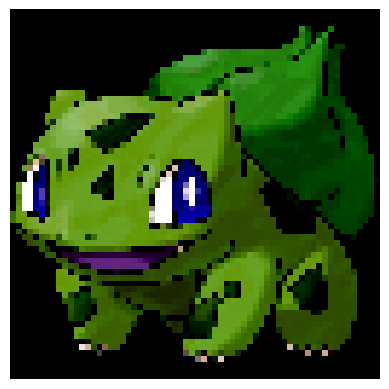

In [3]:
import matplotlib.pyplot as plt

# Afficher la première image du lot
plt.imshow(images[0])
plt.axis("off")
plt.show()

In [4]:
from tensorflow.keras import layers, models

# Fonction pour construire le modèle générateur
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(7*7*128, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((7, 7, 128)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(3, (7, 7), activation='tanh', padding='same'))  # Utilisation de l'activation tanh pour générer des valeurs entre -1 et 1
    
    # Compiler le modèle
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

# Dimension de l'espace latent
latent_dim = 100

# Construire le générateur
generator = build_generator(latent_dim)
generator.summary()

c:\Users\eugen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\eugen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 3)      │        18,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,176,835 (4.49 MB)

 Trainable params: 1,176,835 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras import layers, models

# Fonction pour construire le modèle discriminateur
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compiler le modèle
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

# Taille des images
input_shape = (64, 64, 3)

# Construire le discriminateur
discriminator = build_discriminator(input_shape)
discriminator.summary()

c:\Users\eugen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import numpy as np
from tensorflow.keras import layers, models

# Fonction pour construire le modèle GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan_model = models.Model(gan_input, gan_output)
    gan_model.compile(loss='binary_crossentropy', optimizer='adam')
    return gan_model

# Fonction pour générer des exemples de données aléatoires
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(n_samples, latent_dim)
    return x_input

# Fonction pour l'entraînement du GAN
def train_gan(generator, discriminator, gan_model, latent_dim, X_real, n_epochs=20, batch_size=128):
    half_batch = int(batch_size / 2)
    for epoch in range(n_epochs):
        for i in range(len(X_real) // batch_size):
            # Sélection d'un sous-ensemble aléatoire des images réelles
            ix = np.random.randint(0, X_real.shape[0], half_batch)
            X_real_batch = X_real[ix]
            # Génération des exemples de données latentes aléatoires
            X_fake_batch = generate_latent_points(latent_dim, half_batch)
            # Génération des exemples de données Pokémon synthétiques
            X_fake_batch = generator.predict(X_fake_batch)
            # Création des étiquettes pour les données réelles et synthétiques
            y_real = np.ones((half_batch, 1))
            y_fake = np.zeros((half_batch, 1))
            # Entraînement du discriminateur sur les données réelles
            d_loss_real = discriminator.train_on_batch(X_real_batch, y_real)
            # Entraînement du discriminateur sur les données synthétiques
            d_loss_fake = discriminator.train_on_batch(X_fake_batch, y_fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Préparation des points de données latentes comme entrée pour le GAN
            X_gan = generate_latent_points(latent_dim, batch_size)
            # Création des étiquettes trompeuses pour les données générées par le générateur
            y_gan = np.ones((batch_size, 1))
            # Entraînement du générateur via le modèle GAN
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Affichage de la progression de l'entraînement
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(X_real) // batch_size}, D Loss={d_loss}, G Loss={g_loss}")

# Paramètres du modèle GAN
latent_dim = 100

# Chargement des données réelles
# Remplacez cette fonction par votre propre méthode de chargement des données réelles
def load_real_samples():
    return images

# Construction du générateur
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128 * 8 * 8, input_dim=latent_dim))
    model.add(layers.Reshape((8, 8, 128)))
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', activation='sigmoid'))
    return model

# Construction du discriminateur
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Paramètres d'entraînement
n_epochs = 20
batch_size = 128

# Chargement des données réelles
images = load_real_samples()

# Taille des images
input_shape = images.shape[1:]

# Compilation du modèle du discriminateur
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Construction du modèle GAN
generator = build_generator(latent_dim)
gan_model = build_gan(generator, discriminator)

# Entraînement du modèle GAN
train_gan(generator, discriminator, gan_model, latent_dim, images, n_epochs=n_epochs, batch_size=batch_size)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Epoch 1, Batch 1/6, D Loss=0.7743316888809204, G Loss=[array(0.7487989, dtype=float32), array(0.7487989, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1, Batch 2/6, D Loss=0.7488309741020203, G Loss=[array(0.7416202, dtype=float32), array(0.7416202, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1, Batch 3/6, D Loss=0.7397645711898804, G Loss=[array(0.7342611, dtype=float32), array(0.7342611, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1, Batch 4/6, D Loss=0.737429141998291, G Loss=[array(0.734647, dtype=float32), array(0.734647, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1, Batch 5/6, D Loss=0.7383414506912231, G Loss=[array(0.7360586, dtype=float32), array(0.7360586, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1, Batch 6/6, D Loss=0.736968994140625, G Loss=[array(0.73567915, dtype=float32), array(0.73567915, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 2, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


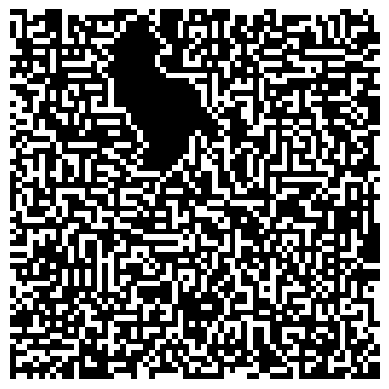

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Définir une fonction pour générer une image aléatoire de Pokémon avec uniquement ses contours
def generate_random_pokemon_contours(generator, latent_dim):
    # Générer un bruit aléatoire
    noise = np.random.normal(0, 1, (1, latent_dim))
    # Utiliser le générateur pour produire une image
    generated_image = generator.predict(noise)
    # Mettre à l'échelle les valeurs des pixels entre 0 et 255
    generated_image = ((generated_image + 1) / 2.0 * 255).astype(np.uint8)
    # Convertir l'image en échelle de gris
    grayscale_image = cv2.cvtColor(generated_image[0], cv2.COLOR_RGB2GRAY)
    # Appliquer un filtre de détection de contours avec des paramètres ajustés
    edges = cv2.Canny(grayscale_image, 50, 150)  # Ajuster les seuils pour un meilleur résultat
    # Créer une image vide pour afficher les contours
    contour_image = np.zeros_like(generated_image[0])
    # Dessiner les contours sur l'image vide
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)
    # Afficher l'image résultante avec uniquement les contours
    plt.imshow(contour_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Utiliser la fonction pour générer une image aléatoire de Pokémon avec uniquement ses contours
generate_random_pokemon_contours(generator, latent_dim)